In [12]:
import numpy as np
from numpy import kron, sqrt, pi, arccos, cos, sin, exp
from numpy.linalg import norm
from numpy.linalg import matrix_power, eig
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import optimize
from matplotlib import pyplot as plt
import functools as ft
import random

In [127]:
def process_fidelity(U0, U1):
    return abs(np.trace(U0 @ U1.conj().transpose())) / len(U0)

def spectral_norm(U0):
    return np.linalg.norm(U0, ord=2)

def local_interaction(n, dict):
    R_list = [I] * n
    for i in dict:
        R_list[i] = dict[i]
    return ft.reduce(kron, R_list)

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1, 0], [0, 1]])
print(expm(1.0j * Z))

[[0.54030231+0.84147098j 0.        +0.j        ]
 [0.        +0.j         0.54030231-0.84147098j]]


In [148]:
H_tmp = []
def trotter_simulation(H_list, n, T, r):
    U1 = np.eye(2 ** n).astype(np.complex128)
    # print(H_list, T, r)
    for H in H_list:
        H_tmp.append(-1.0j * H * T / r)
        U1 = U1 @ expm(-1.0j * H * T / r)
    return matrix_power(U1, r)

def trotter_error(H_list, n_qubit, T, r):
    U_target = expm(-1.0j* sum(H_list) * T)
    U_impl = trotter_simulation(H_list, n_qubit, T, r)
    return spectral_norm(U_impl - U_target)

def commutator(A, B):
    return A@B - B@A

def bipartite_search(error, H_list, n, T, left_r, right_r, eps):
    if right_r < 0:
        right_r = left_r + 1
        while (error(H_list, n, T, right_r) > eps):
            right_r *= 8
    while not (error(H_list, n, T, left_r) <= eps or right_r == left_r + 1):
        print(left_r, right_r)
        mid = (left_r + right_r) // 2
        if (error(H_list, n, T, mid) >= eps):
            left_r = mid
        else:
            right_r = mid
    return left_r

def error(H_list, n, T, r):
    return 1.0/r
print(bipartite_search(error, [], 0, 0, 100, 1e7, 1e-2))

100


In [98]:
def neighbor_heisenberg(n_qubit):
    edges = []
    for i in range(n_qubit-1):
        edges.append((i, i+1))
    edges.append((0, n_qubit-1))
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)

    for i, j in edges:
        XX += local_interaction(n_qubit, {i:X, j:X})
        YY += local_interaction(n_qubit, {i:Y, j:Y})
        if j < n_qubit - 1:
            ZZ += local_interaction(n_qubit, {i:Z, j+1:Z})

    # for i in range(n_qubit):
    #     ZZ += random.random() * local_interaction(n_qubit, {i:Z})
    return [XX, YY, ZZ]

def power_law_heisenberg(n_qubit, r):
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128) 
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    for i in range(n_qubit):
        for j in range(i):
            w = 1 / (j-i) ** r
            XX += local_interaction(n_qubit, {i:X, j:X}) * w
            YY += local_interaction(n_qubit, {i:Y, j:Y}) * w
            ZZ += local_interaction(n_qubit, {i:Z, j:Z}) * w
    for i in range(n_qubit):
        YY += 0 * local_interaction(n_qubit, {i:Y})
    return [XX, YY, ZZ]

def random_heisenberg(n_qubit):
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128) 
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    for i in range(n_qubit):
        for j in range(i):
            XX += local_interaction(n_qubit, {i:X, j:X}) * random.random()
            YY += local_interaction(n_qubit, {i:Y, j:Y}) * random.random()
            ZZ += local_interaction(n_qubit, {i:Z, j:Z}) * random.random()
    return [XX, YY, ZZ]    

In [104]:
def triangle_bound(H_list, n_qubit, T, r):
    sum_norm_commutator = 0
    k = len(H_list)
    for i in range(k):
        cumsum_H = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
        for j in range(i+1, k):
            cumsum_H += H_list[j]
        sum_norm_commutator += spectral_norm(commutator(H_list[i], cumsum_H))
    return 0.5 * T ** 2 * sum_norm_commutator / r

def accumulated_bound(H_list, n_qubit, T, r):
    step_error = trotter_error(H_list, n_qubit, T/r, 1)
    return step_error * r

def eig_overlap(H_list):
    n = len(H_list)
    T = np.zeros_like(H_list[0])
    for i in range(n):
        for j in range(i):
            T += commutator(H_list[j], H_list[i])
    R = sum(H_list)
    eigenvalues, eigenvectors = eig(R)
    correlation = []
    for i in range(len(eigenvalues)):
        v = eigenvectors[i]
        print(np.around(eigenvalues[i], decimals=6), np.around(v @ T @ v.conj().transpose(), decimals=6))
        correlation.append(abs(v @ T @ v.conj().transpose()))
    return max(correlation)

In [136]:
n_max = 10
r_max = 100
decay_coef = 1
T_max = 100
eps = 1e-5
T = 10
r_list = []
error_list = {}

mode_find_r_range_n = False
mode_find_error_range_r = False
mode_find_error_range_T = False
mode_find_error_range_n = True

if mode_find_error_range_n:
    r = 5000
    for n in range(2, 10):
        H_list = neighbor_heisenberg(n)
        error_list[n] = trotter_error(H_list, n, T, r)
    print(error_list)

if mode_find_error_range_r:
    for r in range(1, r_max):
        n = 5
        H_list = power_law_heisenberg(n, decay_coef)
        error_list[r*100] = trotter_error(H_list, n, T, r*100)
    print(error_list)
    
if mode_find_error_range_T:
    for T in range(1, T_max):
        n = 5
        r = 500
        H_list = power_law_heisenberg(n, decay_coef)
        error_list[T] = trotter_error(H_list, n, T, r)
        print(error_list)

if mode_find_r_range_n:
    for n in range(3, n_max):
        r = 1
        k = 1
        H_list = power_law_heisenberg(n, decay_coef)
        while (True):
            if (trotter_error(H_list, n, T, r+1) < eps):
                break
            if (trotter_error(H_list, n, T, r+k) < eps):
                k = k // 2
                continue
            r = r+k
            if r == k * 2:
                k *= 2
            print(r)
        r_list.append(r)
    print(r_list)

{2: 1.1120163218650156e-12, 3: 0.004903397157822819, 4: 0.006451755304567083, 5: 0.007517055888664405, 6: 0.03414683994206796, 7: 0.024787193759382365, 8: 0.031287414857760015, 9: 0.03346273909320222}


In [7]:


n_max = 12
T_max = 500
r_max = 500
triangle_error = {}
trotter_error_list = {}
accumulated_error = {}
ratio_list ={}
for r in range(1, r_max):
    n = 7
    T = 5
    H_list = power_law_heisenberg(n, 0)
    triangle_error[r] = triangle_bound(H_list, n, T, r*100)
    trotter_error_list[r] = trotter_error(H_list, n, T, r*100)
    accumulated_error[r] = accumulated_bound(H_list, n, T, r*100)
    ratio_list[r] = trotter_error_list[r] / accumulated_error[r]
    # print(triangle_error[n])
    # print(trotter_error_list[n])
    print(trotter_error_list[r]/ accumulated_error[r])
print(triangle_error)
print(trotter_error_list)
print(ratio_list)

In [149]:
# n = 8
eps = 1e-2
# T = n
# H_list = power_law_heisenberg(n, 0)
# print(bipartite_search(triangle_bound, H_list, n, T, 1, -1, eps))
# print(bipartite_search(trotter_error, H_list, n, T, 1, -1, eps))
n_max = 10
traingle_r = {}
trotter_r = {}
for n in range(3, n_max):
    T = n
    H_list = np.around(random_heisenberg(n), decimals=6)
    # print(H_list)
    traingle_r[n] = bipartite_search(accumulated_bound, H_list, n, T, 1, 10000000, eps)
    trotter_r[n] = bipartite_search(trotter_error, H_list, n, T, 1, 10000000, eps)
print(traingle_r, trotter_r)

1 10000000
1 5000000
1 2500000
1 1250000
1 625000
1 312500
1 156250
1 78125
1 39063
1 19532
1 9766
1 4883
1 2442
1 1221
1 611
306 611
306 458
382 458
382 420
401 420
410 420
410 415
410 412
1 10000000
1 5000000
1 2500000
1 1250000
1 625000
1 312500
1 156250
1 78125
1 39063
1 19532
1 9766
1 4883
1 2442
1 1221
1 611
1 306
153 306
153 229
153 191
153 172
153 162
157 162
157 159
1 10000000
1 5000000
1 2500000
1 1250000
1 625000
1 312500
1 156250
1 78125
1 39063
1 19532
1 9766
4883 9766
7324 9766
8545 9766
8545 9155
8545 8850
8697 8850
8773 8850
8773 8811
8773 8792
8773 8782
8773 8777
8773 8775
1 10000000
1 5000000
1 2500000
1 1250000
1 625000
1 312500
1 156250
1 78125
1 39063
1 19532
1 9766
1 4883
1 2442
1221 2442
1221 1831
1526 1831
1526 1678
1602 1678
1602 1640
1621 1640
1630 1640
1635 1640
1637 1640
1 10000000
1 5000000
1 2500000
1 1250000
1 625000
1 312500
1 156250
1 78125
1 39063
19532 39063
19532 29297
19532 24414
19532 21973
19532 20752
20142 20752
20142 20447
20142 20294
20142 2021

In [233]:
n = 5
H_list = random_heisenberg(n)
R = sum(H_list)
T = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
eigenvalues, eigenvectors = eig(R)
correlation = []
# for i in range(20):
#     print(np.trace(matrix_power(R, i) @ T))
for i in range(len(eigenvalues)):
    v = eigenvectors[i]
    print(np.around(eigenvalues[i], decimals=6), np.around(v @ T @ v.conj().transpose(), decimals=6))
    correlation.append(abs(v @ T @ v.conj().transpose()))
print(max(correlation))

# eigen_overlap = {}
# for i in range(401):
#     r = i / 100
#     print(r, eig_overlap(power_law_heisenberg(n,r)))
#     eigen_overlap[r] = eig_overlap(power_law_heisenberg(n,r))
# print(eigen_overlap)

(6.327958+0j) (-0+0j)
(5.723665+0j) (-0+0j)
(6.327958+0j) (-0+0j)
(5.723665+0j) (-0+0j)
(4.112343+0j) (-0+0j)
(4.112343+0j) (-0+0j)
(-4.442962+0j) (-0+0j)
(-4.442962+0j) (-0+0j)
(-3.501607+0j) 0j
(-3.781182+0j) 0j
(-3.781182+0j) 0j
(-3.501607+0j) 0j
(1.631106+0j) 0j
(1.631106+0j) (-0+0j)
(-2.454457+0j) 0j
(-2.454457+0j) 0j
(-2.698693+0j) (-0+0j)
(-2.698693+0j) (-0+0j)
(-1.398517+0j) 0j
(-1.398517+0j) 0j
(0.903412+0j) (-0+0j)
(0.903412+0j) 0j
(-0.924648+0j) 0j
(-0.924648+0j) 0j
(0.636355+0j) (-0+0j)
(0.636355+0j) 0j
(0.466128+0j) 0j
(0.466128+0j) (-0+0j)
(0.073319+0j) 0j
(0.073319+0j) 0j
(-0.67222+0j) 0j
(-0.67222+0j) 0j
3.885780586188048e-16


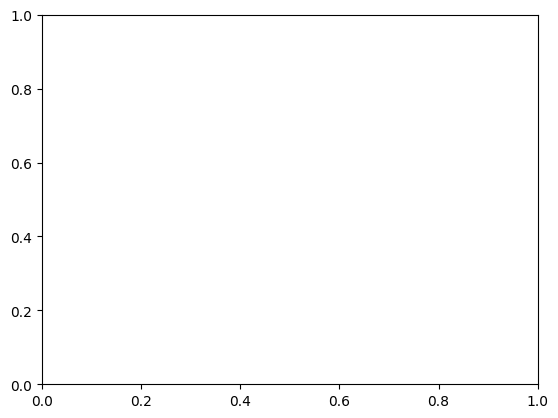

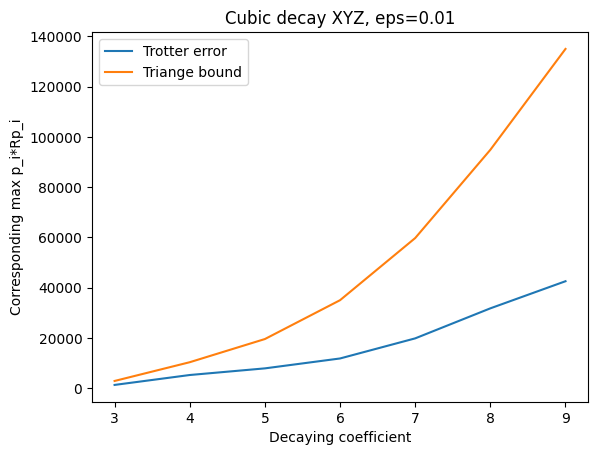

In [118]:
plt.cla()
fig, ax = plt.subplots()
x_list = []
y_list = []
y1_list = []
for n in trotter_r:
    y_list.append(trotter_r[n])
    x_list.append(n)
    y1_list.append(traingle_r[n])
ax.plot(x_list, y_list, label = "Trotter error")
ax.plot(x_list, y1_list, label = "Triange bound")
ax.set_title(f"Cubic decay XYZ, eps={eps}")
ax.set_xlabel("Decaying coefficient")
ax.set_ylabel("Corresponding max p_i*Rp_i")
ax.legend(loc = "best")
plt.show()

#TODO:
#T=n，给定eps 算threshold r ** most important
#Choss small T s.t. linear then quadratic
#other's theory: triangle inequality |[A, B]+[B, C]+[A, C]|
#our theory: interference bound O(poly(n)T^3/r^2+ n T/r) \sum [H_i, H_j] T^2 / r, specify the constant hided by O
#sum up overleaf document
#future: high-order lower bound, how to act interferecne
#

In [145]:
print(expm(H_tmp[-1]))

[[1.00000141-0.j 0.        -0.j 0.        -0.j 0.        -0.j
  0.        -0.j 0.        -0.j 0.        -0.j 0.        -0.j]
 [0.        -0.j 0.99999979-0.j 0.        -0.j 0.        -0.j
  0.        -0.j 0.        -0.j 0.        -0.j 0.        -0.j]
 [0.        -0.j 0.        -0.j 0.99999901-0.j 0.        -0.j
  0.        -0.j 0.        -0.j 0.        -0.j 0.        -0.j]
 [0.        -0.j 0.        -0.j 0.        -0.j 0.99999979-0.j
  0.        -0.j 0.        -0.j 0.        -0.j 0.        -0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.99999979+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.99999901+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.99999979+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 1.00000141+0.j]]